<a href="https://colab.research.google.com/github/fazaghifari/Notebook-Collections/blob/master/computervision/cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple implementation of CNN on CIFAR-10
---
In this notebook, a simple CNN without transfer learning is implemented to classify images based on CIFAR-10 dataset.

CIFAR-10 dataset consists of small color images that fall into one of ten classes; some example images are pictured below.

<img src='https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png' width=50% height=50% />

### Check [CUDA](http://pytorch.org/docs/stable/cuda.html)

Check if GPU is available

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    print(f'Device name = {torch.cuda.get_device_name(0)}')

CUDA is available!  Training on GPU ...
Device name = Tesla P100-PCIE-16GB


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

# Transforms data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
    ])

transform_test = transforms.Compose([ transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

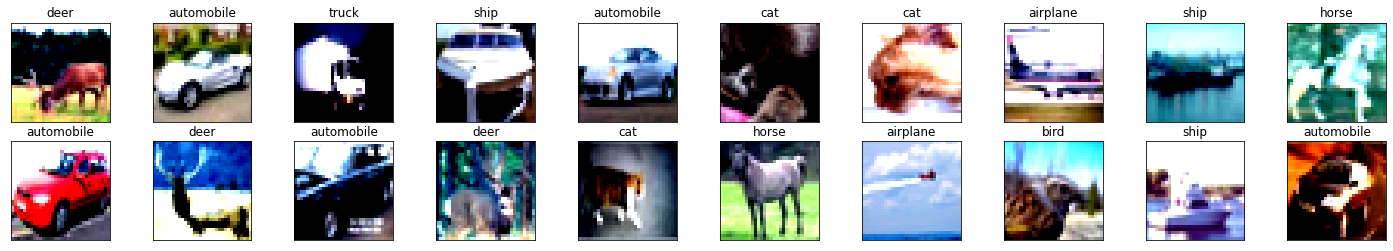

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

High accuracy on CIFAR-10 can be obtained through transfer learning process since a lot of pre-trained models are quite big and have been trained on more sophisticated dataset. However, since we are not using any kind of pre-trained model, we have to define our model. There are 5 main components in this network namely: 

*   Convolutional layer (Conv2d)
*   Max Pooling layer (MaxPool2d)
*   Batch Normalization (BatchNorm2d)
*   Dropout Layer (Dropout)
*   Dense Layer (Linear)

The convolutional layer gradually increase the number of features from 3 to 256 with `padding = 1` which keeps the size of the image through the convolutional layers. Meanwhile, the size of the image is gradually reduced from 32 x 32 into 4 x 4 by using the max pooling layer.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv11 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv12 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv21 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv22 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv31 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv32 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.2)
        self.dense1 = nn.Linear(4*4*256, 1024)
        self.dense2 = nn.Linear(1024,512)
        self.dense3 = nn.Linear(512,10)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.bn1(self.conv11(x)))
        x = self.dropout(self.pool(F.relu(self.conv12(x))))
        x = F.relu(self.bn2(self.conv21(x)))
        x = self.dropout(self.pool(F.relu(self.conv22(x))))
        x = F.relu(self.bn3(self.conv31(x)))
        x = self.dropout(self.pool(F.relu(self.conv32(x))))
        x = x.view(-1, 256*4*4)
        x = self.dense3(self.dropout(self.dense2(F.relu(self.dense1(x)))))
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=4096, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=512, bi

---
## Train the Network

In [6]:
import time
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 50 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss
trainloss_list = []
valloss_list = []
valacc_list = []

for epoch in range(1, n_epochs+1):
    t0 = time.time()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    accuracy = 0.0
    with torch.no_grad():
        for ii, (data, target) in enumerate(valid_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()
            ps = torch.softmax(output, dim=1)
            _, pred = torch.max(output, 1)
            equals = pred.eq(target.data.view_as(pred))
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # print('accuracy = ',accuracy) if ii%50 == 0 else None

    
    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    valid_acc = accuracy/len(valid_loader)
    
    trainloss_list.append(train_loss)
    valloss_list.append(valid_loss)
    valacc_list.append(valid_acc)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.3f} \tTime elapsed: {:.1f}s'.format(
        epoch, train_loss, valid_loss, valid_acc, time.time()-t0))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.754585 	Validation Loss: 1.507082 	Validation Accuracy: 0.431 	Time elapsed: 21.9s
Epoch: 2 	Training Loss: 1.495179 	Validation Loss: 1.375886 	Validation Accuracy: 0.496 	Time elapsed: 21.9s
Epoch: 3 	Training Loss: 1.331148 	Validation Loss: 1.163274 	Validation Accuracy: 0.587 	Time elapsed: 21.8s
Epoch: 4 	Training Loss: 1.191976 	Validation Loss: 1.139918 	Validation Accuracy: 0.596 	Time elapsed: 21.7s
Epoch: 5 	Training Loss: 1.079685 	Validation Loss: 0.960053 	Validation Accuracy: 0.657 	Time elapsed: 22.0s
Epoch: 6 	Training Loss: 0.988340 	Validation Loss: 0.901127 	Validation Accuracy: 0.678 	Time elapsed: 21.6s
Epoch: 7 	Training Loss: 0.921343 	Validation Loss: 0.827104 	Validation Accuracy: 0.712 	Time elapsed: 21.6s
Epoch: 8 	Training Loss: 0.844340 	Validation Loss: 0.816127 	Validation Accuracy: 0.715 	Time elapsed: 21.6s
Epoch: 9 	Training Loss: 0.794220 	Validation Loss: 0.713309 	Validation Accuracy: 0.750 	Time elapsed: 21.6s
Epoch: 10 

### Plot Loss and Accuracy

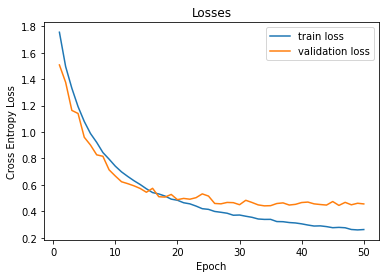

In [7]:
epochs = np.arange(1, n_epochs+1)
plt.plot(epochs, np.array(trainloss_list), label='train loss')
plt.plot(epochs, np.array(valloss_list), label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Losses')
plt.show()

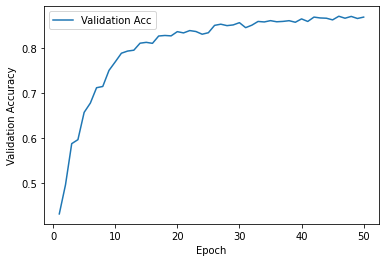

In [8]:
plt.plot(epochs, np.array(valacc_list), label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

###  Load the Model with the Lowest Validation Loss

In [9]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [10]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.446808

Test Accuracy of airplane: 86% (867/1000)
Test Accuracy of automobile: 91% (914/1000)
Test Accuracy of  bird: 82% (824/1000)
Test Accuracy of   cat: 72% (728/1000)
Test Accuracy of  deer: 86% (863/1000)
Test Accuracy of   dog: 78% (780/1000)
Test Accuracy of  frog: 92% (928/1000)
Test Accuracy of horse: 86% (863/1000)
Test Accuracy of  ship: 93% (932/1000)
Test Accuracy of truck: 92% (926/1000)

Test Accuracy (Overall): 86% (8625/10000)
